In [1]:
import pandas as pd
import numpy as np
import scipy as sp 
import os
import sklearn.preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from wrangle import get_city_climate_data, prep_houston, numeric_hist_maker, split_houston_data, plot_and_eval
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 80)

# ACQUIRE

In [2]:
acquire= get_city_climate_data()

In [3]:
acquire.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
acquire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [5]:
acquire.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

- This is a large data frame with 8599212 entries
- There are 364130 null values in the average temperature and average temperature uncertainity columns.
- For the purpose of this project, I am going to filter out data to focus solely on Houston, Texas, USA.

# PREPARE

In [6]:
df= prep_houston()

In [7]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1820-01-01,8.046,3.739
1820-02-01,12.228,2.978
1820-03-01,15.480,2.341
1820-04-01,21.327,2.051
1820-05-01,24.047,1.782


<Figure size 936x648 with 0 Axes>

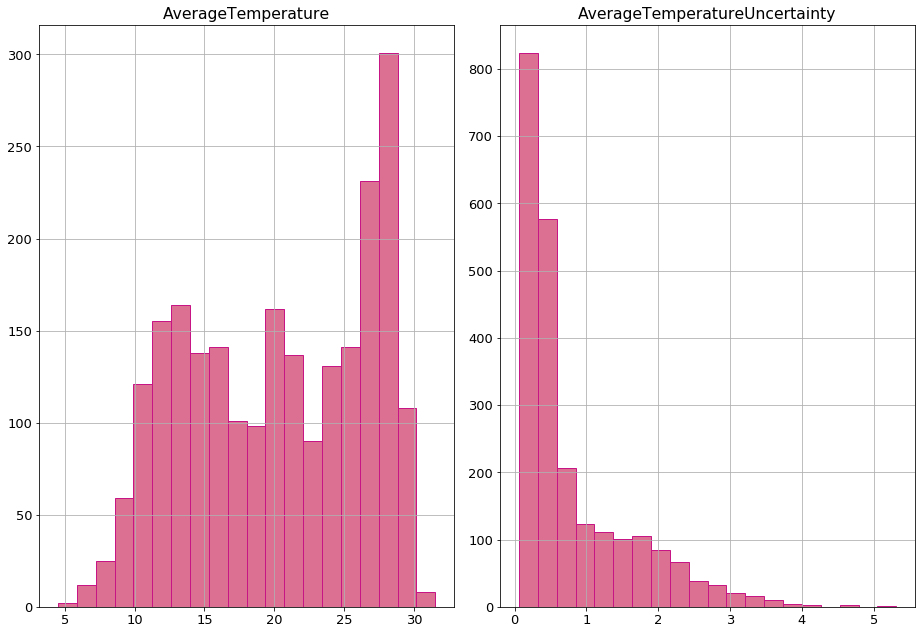

In [8]:
hist= numeric_hist_maker(df, bins=20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 1820-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             2325 non-null   float64
 1   AverageTemperatureUncertainty  2325 non-null   float64
dtypes: float64(2)
memory usage: 54.5 KB


In [10]:
#Describe the numerical data
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,2325.000000,2325.000000
mean,20.228964,0.811532
std,6.446669,0.795379
min,4.514000,0.060000
25%,14.365000,0.273000
50%,20.560000,0.428000
75%,26.559000,1.151000
max,31.518000,5.312000


Text(0.5, 0.98, 'Plot of average temperatures by year')

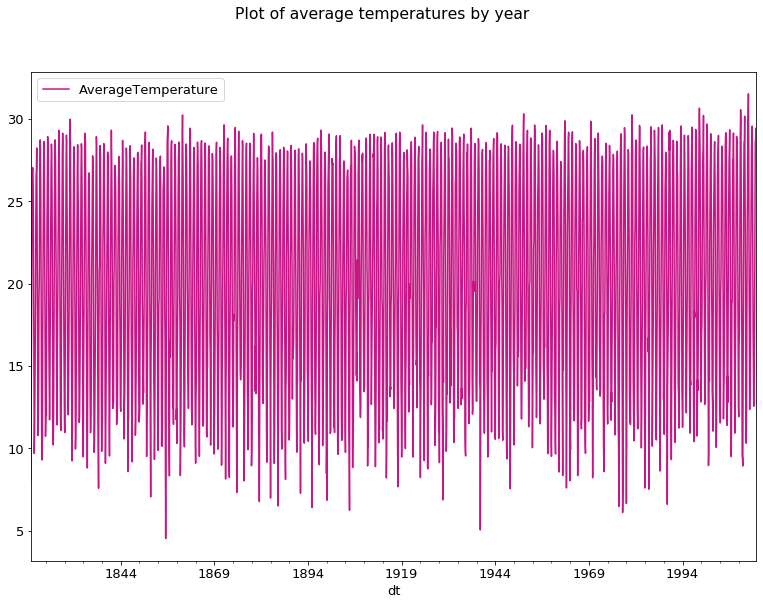

In [11]:
by_date = df.groupby(['dt']).AverageTemperature.sum().reset_index()
by_date.plot(x='dt', y='AverageTemperature', color= 'mediumvioletred')
plt.suptitle('Plot of average temperatures by year')

In [12]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)

Number of rows: 2325
Number of days between first and last day: 70737 days 00:00:00


# EXPLORE

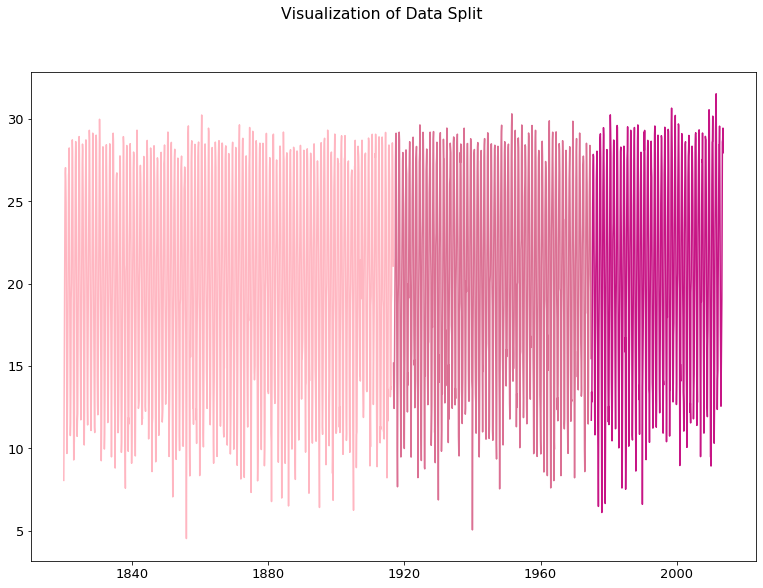

In [13]:
train, validate, test = split_houston_data()
plt.suptitle('Visualization of Data Split')
plt.plot(train.index, train.AverageTemperature, color='lightpink')
plt.plot(validate.index, validate.AverageTemperature, color='palevioletred')
plt.plot(test.index, test.AverageTemperature, color='mediumvioletred')

In [14]:
#The target in a variable stored under y for ease of access.
y = train.AverageTemperature
y.head()

dt
1820-01-01     8.046
1820-02-01    12.228
1820-03-01    15.480
1820-04-01    21.327
1820-05-01    24.047
Name: AverageTemperature, dtype: float64

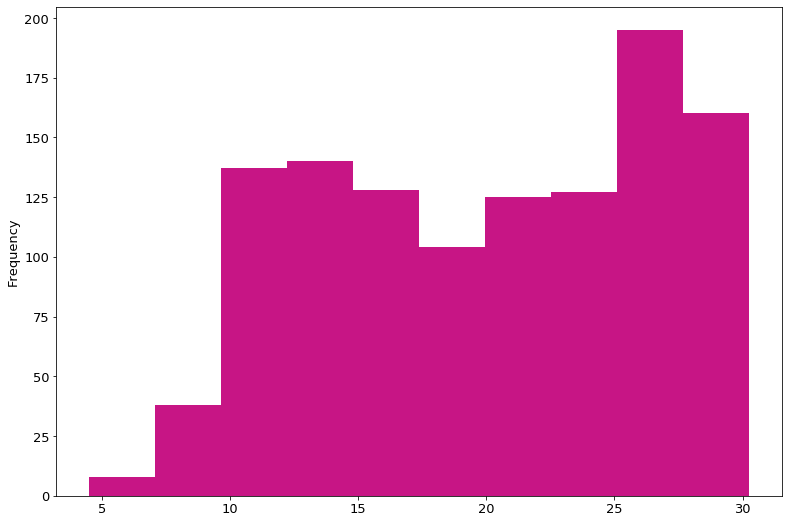

In [15]:
y.plot.hist(color='mediumvioletred')

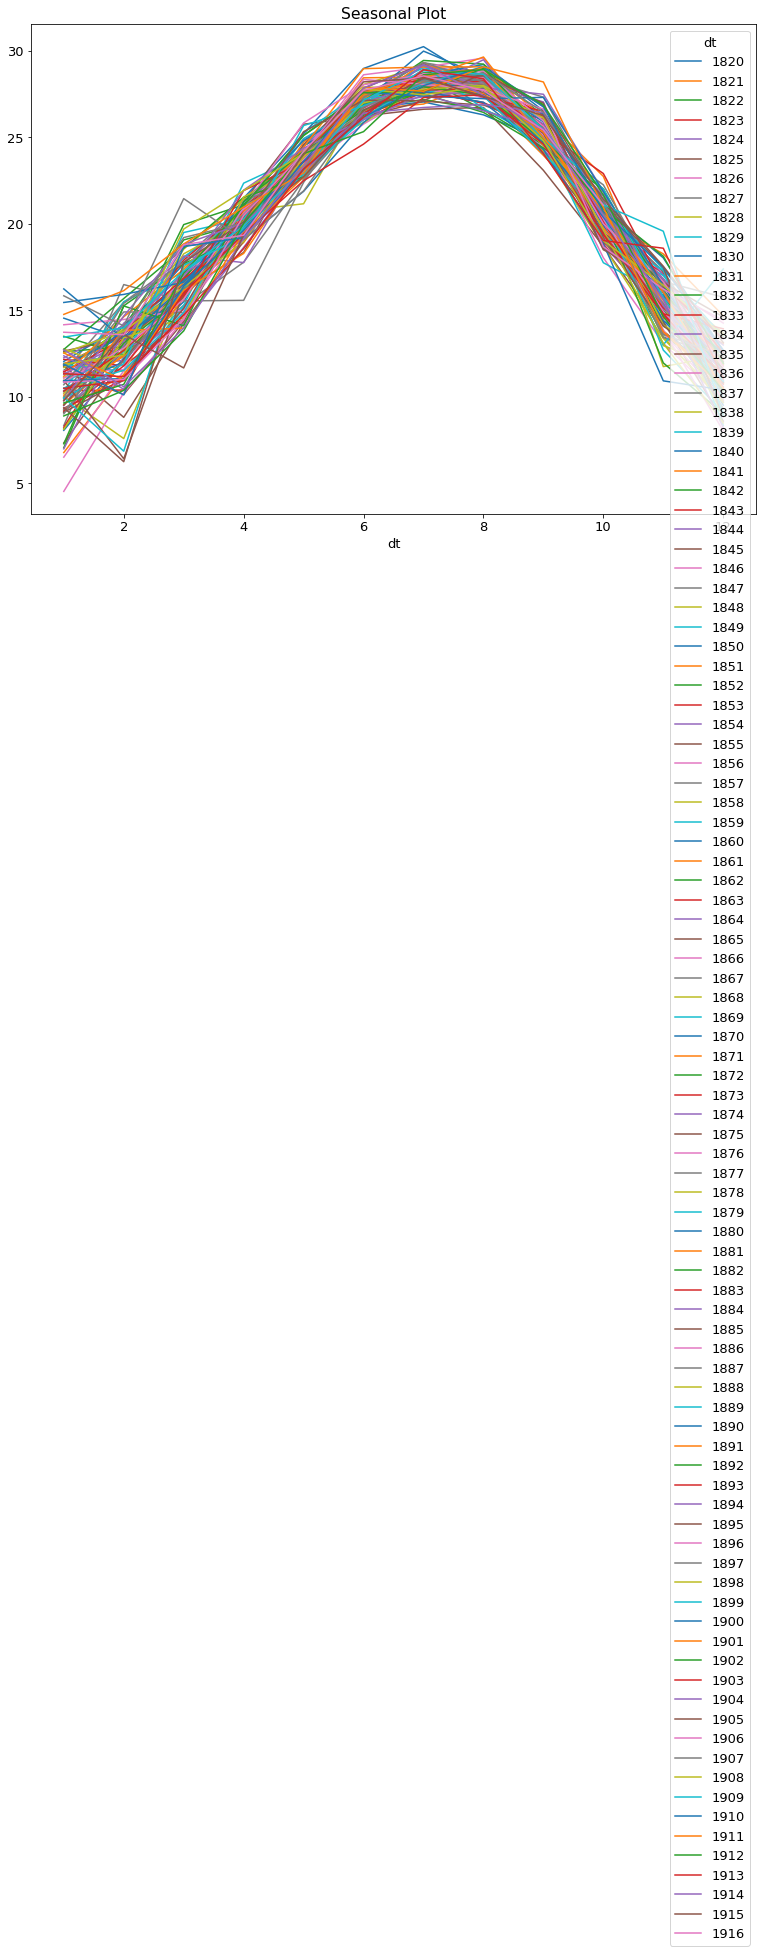

In [16]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

[Text(0, 0.5, 'Temp (C)'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Temperature by Month')]

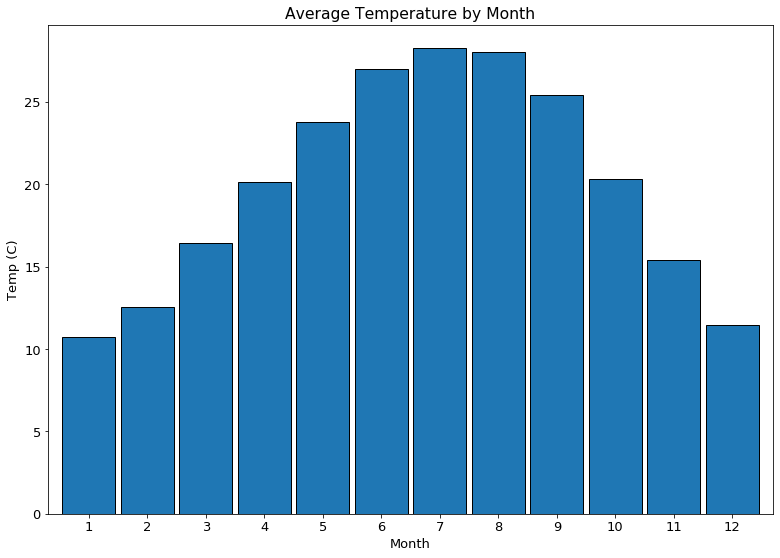

In [17]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (C)')

Text(0.5, 1.0, 'Lag plot with lag=1')

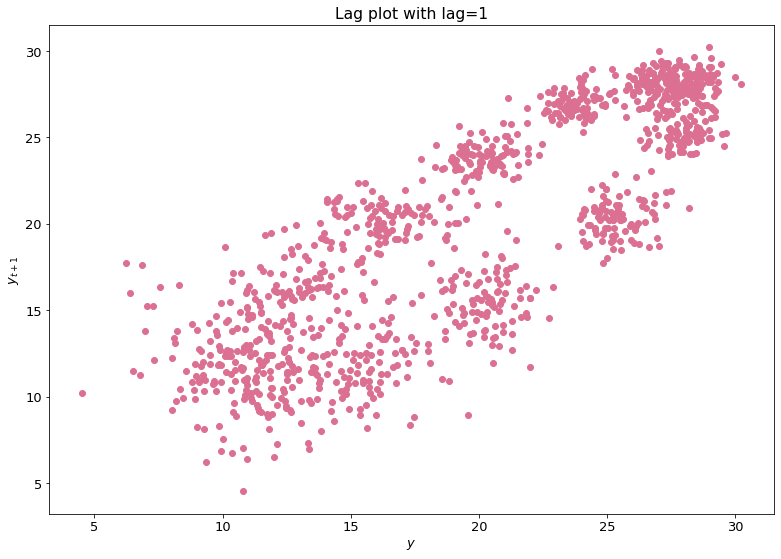

In [18]:
plt.scatter(y, y.shift(-1), color='palevioletred')
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

[Text(0, 0.5, 't + 1'), Text(0.5, 0, 't')]

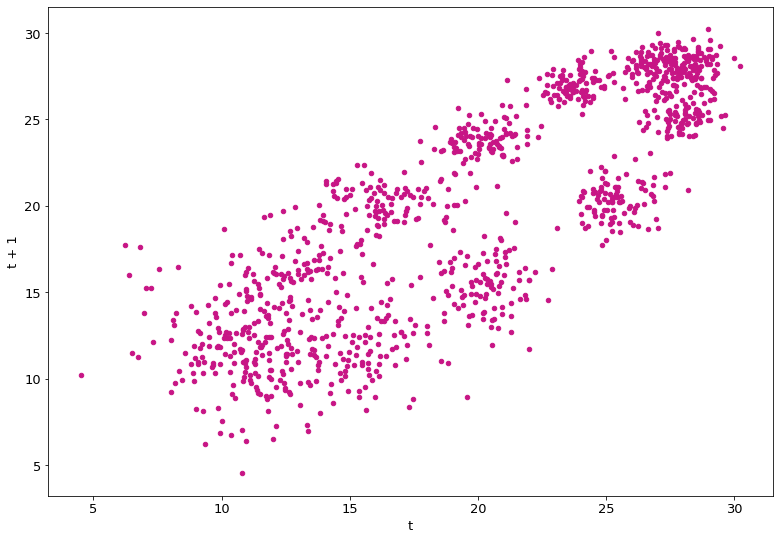

In [19]:
train['y(t + 1)'] = train.AverageTemperature.shift(-1)
ax = train.plot.scatter(x='AverageTemperature', y='y(t + 1)', color='mediumvioletred')
ax.set(xlabel='t', ylabel='t + 1')

In [20]:
train.head()

,AverageTemperature,AverageTemperatureUncertainty,y(t + 1)
dt,,,
1820-01-01,8.046,3.739,12.228
1820-02-01,12.228,2.978,15.480
1820-03-01,15.480,2.341,21.327
1820-04-01,21.327,2.051,24.047
1820-05-01,24.047,1.782,26.679


# MODEL

### Make Predictions

In [21]:
avg_temp = train['AverageTemperature'][-1:][0]
avg_temp_unc = train['AverageTemperatureUncertainty'][-1:][0]

yhat_df = pd.DataFrame({'AverageTemperature': [avg_temp], 'AverageTemperatureUncertainty': [avg_temp_unc]}, 
                       index = validate.index)

yhat_df.head(2)

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1916-11-01,21.056,0.47
1916-12-01,21.056,0.47


In [22]:
for col in train.columns:
    plot_and_eval(col)

NameError: name 'train' is not defined

<Figure size 864x288 with 0 Axes>

## Last Observed Value